In [3]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import xgboost as xgb
import imblearn as imb

In [4]:
#readin in data
df=pd.read_csv("Churn_Preprocessed.csv")

In [5]:
df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_female,gender_male,Partner_no,Partner_yes,Dependents_no,Dependents_yes,...,Contract_month_to_month,Contract_one_year,Contract_two_year,PaperlessBilling_no,PaperlessBilling_yes,PaymentMethod_bank_transfer_(automatic),PaymentMethod_credit_card_(automatic),PaymentMethod_electronic_check,PaymentMethod_mailed_check,Churn
0,0,1,29.85,29.85,True,False,False,True,True,False,...,True,False,False,False,True,False,False,True,False,False
1,0,34,56.95,1889.50,False,True,True,False,True,False,...,False,True,False,True,False,False,False,False,True,False
2,0,2,53.85,108.15,False,True,True,False,True,False,...,True,False,False,False,True,False,False,False,True,True
3,0,45,42.30,1840.75,False,True,True,False,True,False,...,False,True,False,True,False,True,False,False,False,False
4,0,2,70.70,151.65,True,False,True,False,True,False,...,True,False,False,False,True,False,False,True,False,True


In [6]:
#Split target and features
y=df.pop("Churn")
X=df

In [7]:
X_train, X_test, y_train, y_test=sk.model_selection.train_test_split(X,y, test_size=.3)

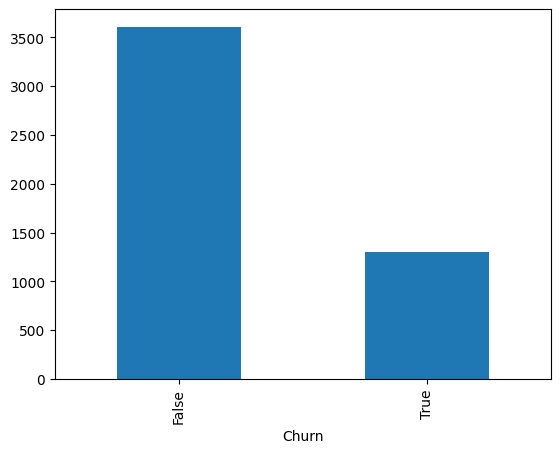

In [8]:
#target imbalance
target_counts=y_train.value_counts()
target_counts.plot(kind='bar')
plt.show()

In [9]:
#smote to fix target imbalance
smote = imb.over_sampling.SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


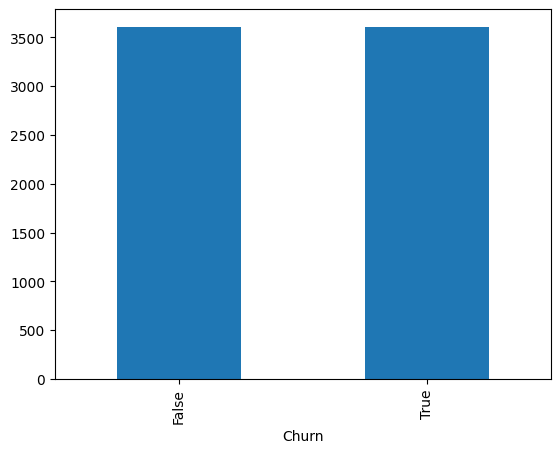

In [10]:
target_counts=y_train_resampled.value_counts()
target_counts.plot(kind='bar')
plt.show()

In [11]:
y_train.value_counts()

Churn
False    3609
True     1305
Name: count, dtype: int64

In [12]:
y_train_resampled.value_counts()

Churn
False    3609
True     3609
Name: count, dtype: int64

In [ ]:
#try random forest out of box on test set
RF_CLF = sk.ensemble.RandomForestClassifier()
RF_CLF.fit(X_train_resampled,y_train_resampled)
yhat_train=RF_CLF.predict(X_test)
print(sk.metrics.classification_report(y_test,yhat_train))

              precision    recall  f1-score   support

       False       0.84      0.87      0.86      1555
        True       0.60      0.53      0.56       552

    accuracy                           0.78      2107
   macro avg       0.72      0.70      0.71      2107
weighted avg       0.78      0.78      0.78      2107



In [55]:
#test xgb out of box 
XGB_CLF=xgb.XGBClassifier()
XGB_CLF.fit(X_train_resampled,y_train_resampled)
yhat_train=XGB_CLF.predict(X_test)
print(sk.metrics.classification_report(y_test,yhat_train))

              precision    recall  f1-score   support

       False       0.83      0.87      0.85      1555
        True       0.58      0.52      0.55       552

    accuracy                           0.77      2107
   macro avg       0.71      0.69      0.70      2107
weighted avg       0.77      0.77      0.77      2107



In [ ]:
#set up the param grid
param_grid = {
    'max_features': ['log2', 'sqrt', 0.5],
    'n_estimators': [200, 500, 800],
    'max_depth': [10, 20, None],
}

In [127]:
#set up the param grid
param_grid = {
    'max_features': ['log2'],
    'n_estimators': [500],
    'max_depth': [10],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 5, 10, 15],
}

In [128]:
RF_CLF = sk.ensemble.RandomForestClassifier()
grid_search=sk.model_selection.GridSearchCV(estimator=RF_CLF,param_grid=param_grid, cv=3, scoring='recall')


In [129]:
grid_search.fit(X_train_resampled,y_train_resampled)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10], 'max_features': ['log2'],
                         'min_samples_leaf': [1, 5, 10, 15],
                         'min_samples_split': [2, 5, 10, 15],
                         'n_estimators': [500]},
             scoring='recall')

In [130]:
print(grid_search.best_params_)

{'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


Out of Box RF performance <br>
                precision   recall  f1-score   support

       False       0.84      0.87      0.86      1555
        True       0.60      0.53      0.56       552

    accuracy       -         -         0.78      2107
    macro avg      0.72      0.70      0.71      2107
    weighted avg   0.78      0.78      0.78      2107

In [ ]:
# RF "Final" model--we aimed to maximize recall as we consider missing at risk customers a higher priority
RF_CLF2=sk.ensemble.RandomForestClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=1,
                       max_features='log2', n_estimators=500)
RF_CLF2.fit(X_train_resampled,y_train_resampled)
yhat=RF_CLF2.predict(X_test)
print(sk.metrics.classification_report(y_test,yhat))

              precision    recall  f1-score   support

       False       0.87      0.84      0.85      1555
        True       0.58      0.64      0.61       552

    accuracy                           0.79      2107
   macro avg       0.72      0.74      0.73      2107
weighted avg       0.79      0.79      0.79      2107



In [132]:
#we can further optimize recall by shifting thrshold, at the cost of overall perforamce
threshold=.35
predicted_proba = RF_CLF2.predict_proba(X_test)
yhat_shift = (predicted_proba [:,1] >= threshold).astype('int')
print(sk.metrics.classification_report(y_test,yhat_shift))

              precision    recall  f1-score   support

       False       0.90      0.73      0.81      1555
        True       0.51      0.78      0.62       552

    accuracy                           0.74      2107
   macro avg       0.71      0.76      0.71      2107
weighted avg       0.80      0.74      0.76      2107



In [133]:
# param grid for xgboost
param_grid2 = {
    'max_depth': [0,1,2,3,4], 
    'gamma': [0, 1, 5],  
    'reg_alpha': [0, 1, 3], 
    'reg_lambda': [0, 1, 3],  
}

In [134]:
# param grid for xgboost
param_grid2 = {
    'max_depth': [1], 
    'gamma': [0],  
    'reg_alpha': [0], 
    'reg_lambda': [0], 
    'colsample_bytree': [0.3, 0.6, 1], 
    'min_child_weight': [3, 5, 10], 
    'n_estimators': range(100, 500, 50), 
}


In [135]:
XGB_CLF=xgb.XGBClassifier()
grid_search2=sk.model_selection.GridSearchCV(estimator=XGB_CLF,param_grid=param_grid2, cv=5, scoring='recall')


In [136]:
grid_search2.fit(X_train_resampled,y_train_resampled)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.6, 1], 'gamma': [0],
                         'max_depth': [1], 'min_child_weight': [3, 5, 10],
                         'n_estimators': range(100, 500, 50), 'reg_alpha': [0],
                         'reg_lambda': [0]},
             scoring='recall')

In [138]:
print(grid_search2.best_params_)

{'colsample_bytree': 1, 'gamma': 0, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0}


Original out of box model <br>
precision    recall  f1-score   support

            False      0.83      0.87      0.85      1555
            True       0.58      0.52      0.55       552

        accuracy       -         -         0.77      2107
        macro avg      0.71      0.69      0.70      2107
        weighted avg   0.77      0.77      0.77      2107


In [ ]:
#XGB "Final" model--we aimed to maximize recall as we consider missing at risk customers a higher priority
XGB_CLF2=xgb.XGBClassifier(colsample_bytree=1, gamma=0, max_depth=1, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=0)
XGB_CLF2.fit(X_train_resampled,y_train_resampled)
yhat=XGB_CLF2.predict(X_test)
print(sk.metrics.classification_report(y_test,yhat))

              precision    recall  f1-score   support

       False       0.87      0.83      0.85      1555
        True       0.59      0.66      0.62       552

    accuracy                           0.79      2107
   macro avg       0.73      0.75      0.74      2107
weighted avg       0.80      0.79      0.79      2107



In [149]:
#Like for the RF, we can further optimize recall by shifting thrshold, at the cost of overall perforamce
threshold=.35
predicted_proba = XGB_CLF2.predict_proba(X_test)
yhat_shift = (predicted_proba [:,1] >= threshold).astype('int')
print(sk.metrics.classification_report(y_test,yhat_shift))

              precision    recall  f1-score   support

       False       0.91      0.71      0.80      1555
        True       0.49      0.79      0.61       552

    accuracy                           0.73      2107
   macro avg       0.70      0.75      0.70      2107
weighted avg       0.80      0.73      0.75      2107



In the end, the tuned XGB model marginally outperforms the tuned RF model in respect to Recall for the churn class, as well as weighted precision, recall, and F1 score, but drastically out performs both untuned models.